## Analysing Cell-Cell Interactions in Colorectal Neoplasia: Figure 1.

This notebook reproduces Figure 1 from the study *Integrating diverse statistical methods to analyse stage-discriminatory cell interactions in colorectal neoplasia* by Bull, Mulholland, Moore, ..., Byrne, and Leedham (2024) (https://doi.org/10.1101/2024.06.02.597010).

In this study, MuSpAn is used to integrate a range of mathematical tools into a suite of spatial descriptors. These descriptors were deployed to study how cell interactions evolve as colorectal cancer progresses from benign precursors to malignant states, demonstrating how combining diverse mathematical analyses can uncover meaningful insights into tissue organisation and identify the variable cell-cell relationships underlying disease progression.

**What This Notebook Covers**

Here, we focus on reproducing Figure 1: Multiple spatial metrics are needed to distinguish different spatial structures. This figure uses synthetic data to illustrate the spatial features captured by a set of spatial metrics, including:

1. Cell counts
2. Wasserstein distance
3. Quadrat correlation matrix (QCM)
4. Topographical correlation map (TCM)
5. Level-set persistent homology (PH)

The synthetic datasets used for this figure are standard examples available in MuSpAn. This means you can fully reproduce the analysis and figure without needing to download any external datasets.

**Key Goals of This Notebook**

1. Demonstrate how to build spatial analysis pipelines using MuSpAn with minimal code.
2. Show how the outputs from MuSpAn can be used to create publication-ready figures.
3. Highlight the differences between spatial metrics as applied to synthetic datasets with increasing complexity.

With this context in mind, let’s get started by importing the necessary libraries!

In [1]:
# Import necessary libraries
import muspan as ms
import numpy as np

# imports for making plots look nice
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the resolution for matplotlib figures
mpl.rcParams['figure.dpi'] = 270

# Define color palettes for plots
ph_colors = sns.color_palette('deep')
point_colors = sns.color_palette('muted')

# Fix the random seed for reproducibility
np.random.seed(130357726)

# marker size for the point clouds
marker_size=2.5

Next we can set up some parameters that will be used in some of the spatial analysis functions.

In [2]:
# Define all possible labels for cell types
all_labels = ['A', 'B', 'C', 'D']

# Define cell pairs for analysis
cell_pair_1 = ['A', 'B']
cell_pair_2 = ['A', 'C']
cell_pair_3 = ['A', 'D']

# Default parameters for Topographical Correlation Map (TCM)
TCM_upper_bound = 14
radius_of_interest = 30
kernel_radius = 150
kernel_sigma = radius_of_interest / 1.5

# Parameters for Pair Correlation Function (PCF)
max_R = 500
annulus_step = 5
annulus_width = 20

# Parameters for Quadrat Correlation Matrix (QCM)
quadrat_size = 100

We can load our synthetic data using the `datasets` submodule in MuSpAn as each of these are standard data stored in MuSpAn for demonstration. These are designed to represent the
variations in cell-cell interactions typical of tissue organisational structures relevant to intestinal cancer samples

1. “Random”, showing spatial independence between points with different labels;
2. “Aggregation”, reflecting dense clustering of some points into subregions of spatial co-location;
3. “Exclusion”, representing segregation of points with different labels into distinct subregions;
4. “Architecture”, representing higher order architectural structures such as colorectal crypts and/or immune aggregates. The stereotypical nature of these structures changes as neoplasia progresses.

While these examples are not exhaustive, they reflect an implicit hierarchy based on the spatial structure of the underlying tissue.

In [3]:
# Load synthetic data of points with different spatial patterns
rand_domain = ms.datasets.load_example_domain('Synthetic-Points-Random')
agg_domain = ms.datasets.load_example_domain('Synthetic-Points-Aggregation')
ex_domain = ms.datasets.load_example_domain('Synthetic-Points-Exclusion')
arch_domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Create a list of domains for analysis
list_of_domains = [rand_domain, agg_domain, ex_domain, arch_domain]

MuSpAn domain loaded successfully. Domain summary:
Domain name: Density
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Aggregation
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


MuSpAn domain loaded successfully. Domain summary:
Domain name: Exclusion
Number of objects: 2166
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


With our domains loaded and parameters defined, we’re ready to loop through each domain to compute key metrics: cell counts, Wasserstein distance, QCM, PCF, TCM, and level-set filtration. Once the computations are complete, we’ll visualise everything in a single figure.

At first glance, the code might seem extensive, but most of it is just for fine-tuning the figure’s appearance. The core spatial analysis pipeline only requires 8 lines of code! We’ve highlighted the sections of the loop responsible for analysis and plotting below. (It takes about 90 seconds to run on an M2 chip.)

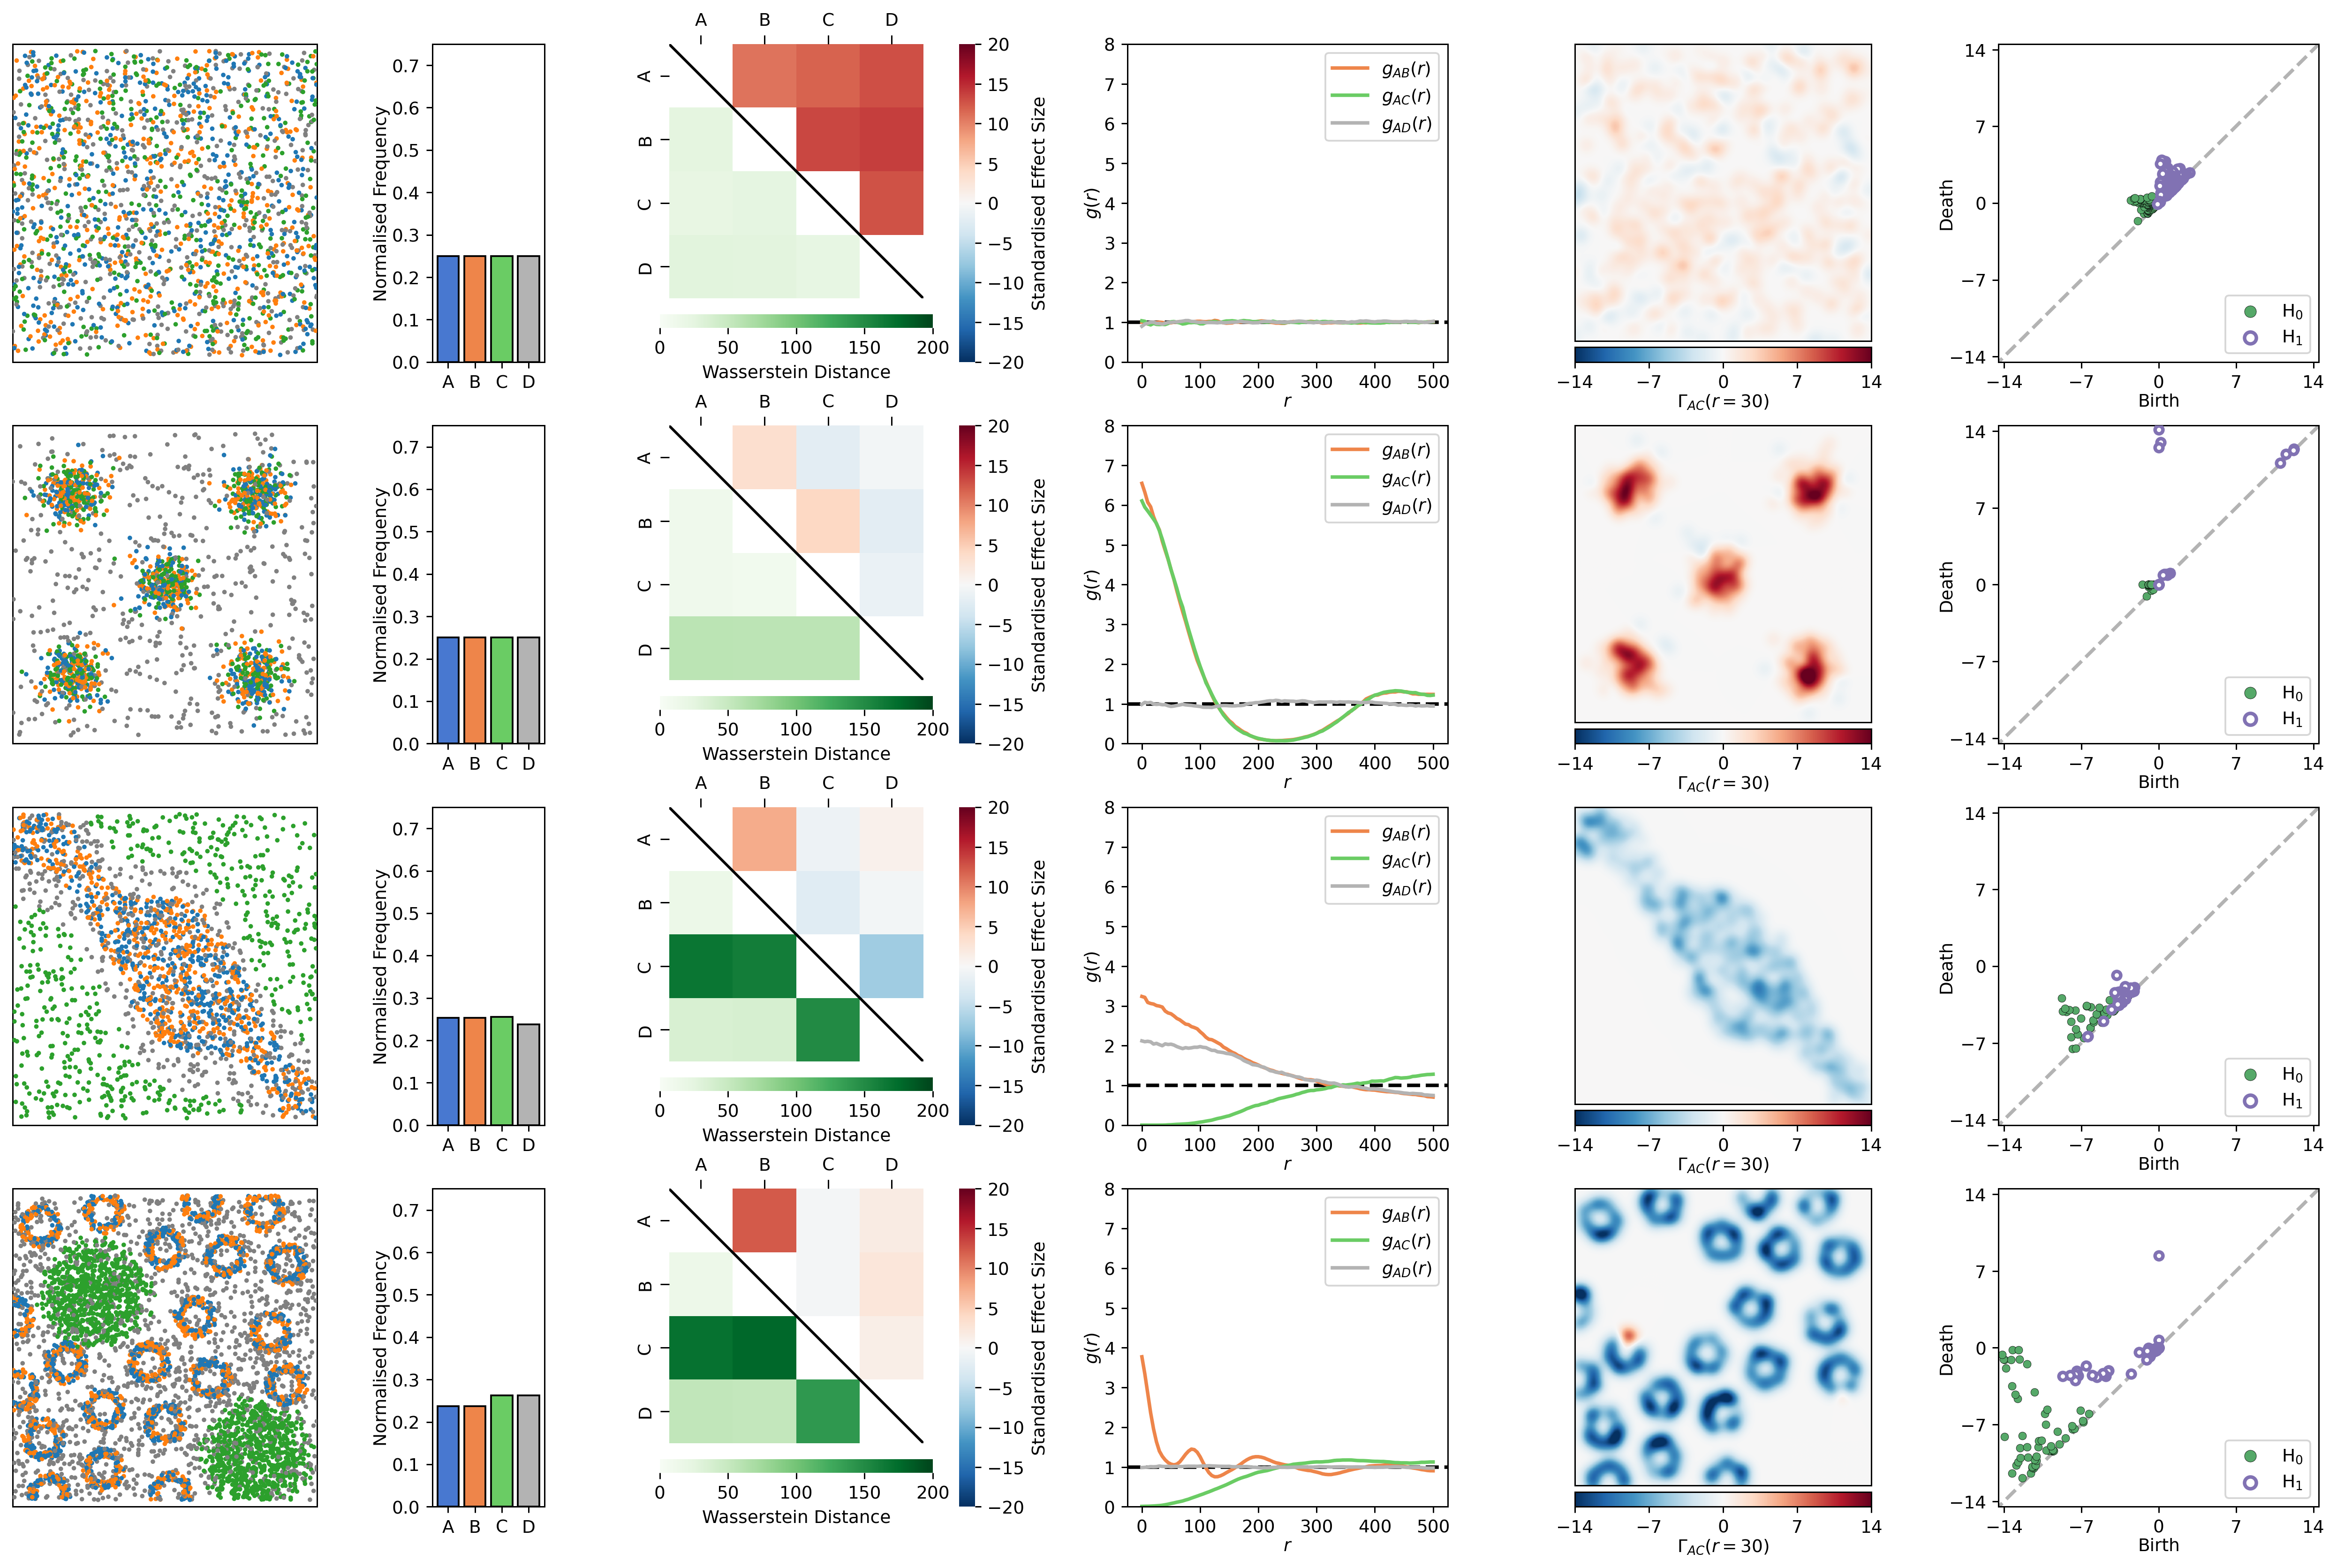

In [4]:
# Create a figure with subplots
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(23.5, 3*5), gridspec_kw={'width_ratios': [0.95, 0.35, 1.1, 1, 1, 1], 'wspace': 0.4})

# Iterate over each domain in the list of domains and run counts, Wasserstein distance, QCM, PCF, TCM and level-set filtration - plot the outputs
for index, domain in enumerate(list_of_domains):
    
    ########## Spatial Analysis ##########
    
    # Calculate normalized counts of cell types
    normalise_counts, labels = ms.summary_statistics.label_counts(domain, label_name='Celltype',normalised=True)

    # Calculate Wasserstein distance matrix
    WassDistMat = np.zeros((len(all_labels), len(all_labels)))
    for i in range(len(all_labels)):
        for j in range(i, len(all_labels)):
            WassDistMat[i, j] = ms.distribution.sliced_wasserstein_distance(domain, population_A=('Celltype', all_labels[i]), population_B=('Celltype', all_labels[j]), POT_args={'n_projections': 1000})
    
    # Calculate Quadrat Correlation Matrix (QCM)
    SES, _, _ = ms.region_based.quadrat_correlation_matrix(domain, label_name='Celltype', region_kwargs=dict(side_length=quadrat_size))

    # Calculate Pair Correlation Function (PCF) for all pairs of interest
    r, g_1 = ms.spatial_statistics.cross_pair_correlation_function(domain, population_A=('Celltype', cell_pair_1[0]), population_B=('Celltype', cell_pair_1[1]), max_R=max_R, annulus_step=annulus_step, annulus_width=annulus_width)
    r, g_2 = ms.spatial_statistics.cross_pair_correlation_function(domain, population_A=('Celltype', cell_pair_2[0]), population_B=('Celltype', cell_pair_2[1]), max_R=max_R, annulus_step=annulus_step, annulus_width=annulus_width)
    r, g_3 = ms.spatial_statistics.cross_pair_correlation_function(domain, population_A=('Celltype', cell_pair_3[0]), population_B=('Celltype', cell_pair_3[1]), max_R=max_R, annulus_step=annulus_step, annulus_width=annulus_width)

    # Calculate Topographical Correlation Map (TCM)
    TCM = ms.spatial_statistics.topographical_correlation_map(domain, population_A=('Celltype', cell_pair_2[0]), population_B=('Celltype', cell_pair_2[1]), radius_of_interest=radius_of_interest, kernel_radius=kernel_radius, kernel_sigma=kernel_sigma)

    # Perform level-set filtration on TCM
    TCM_persistence = ms.topology.level_set_filtration(TCM)
    
    
    
    ########## Plot the outputs ##########
    
    # Plot domain
    ms.visualise.visualise(domain, 'Celltype', ax=axs[index, 0], add_cbar=False, marker_size=marker_size)
    axs[index, 0].set_xticks([])
    axs[index, 0].set_yticks([])
    axs[index, 0].set_xlim(0, 1000)
    axs[index, 0].set_ylim(0, 1000)
    
    # Plot normalised counts
    axs[index, 1].bar(labels, normalise_counts, color=[point_colors[0], point_colors[1], point_colors[2], [0.7, 0.7, 0.7, 1]], linestyle='-', edgecolor='k')
    axs[index, 1].set_ylabel('Normalised Frequency', labelpad=1)
    axs[index, 1].set_ylim(0, 0.75)

    # Plot Wasserstein distance and QCM
    mask = 1 - np.tri(SES.shape[0], k=-1)
    mask2 = 1 - np.tri(WassDistMat.shape[0], k=1)
    A_plot = np.ma.array(SES, mask=mask, fill_value=np.nan)
    WassPlotMat = np.ma.array(WassDistMat, mask=mask2, fill_value=np.nan)
    WassPlotMat[WassPlotMat == 0] = np.nan
    A_plot[A_plot == 0] = np.nan
    cmap = plt.get_cmap('RdBu_r')
    cmap.set_bad('w')

    sns.heatmap(A_plot, vmax=20, vmin=-20, yticklabels=all_labels, xticklabels=all_labels, linewidths=0, linecolor='k',
                ax=axs[index, 2], square='True', cmap='RdBu_r', cbar_kws=dict(use_gridspec=False, location="right", label='Standardised Effect Size', pad=0.075))
    sns.heatmap(WassPlotMat.T, vmax=0, vmin=200, yticklabels=all_labels, xticklabels=all_labels, linewidths=0, linecolor='k',
                ax=axs[index, 2], square='True', cmap='Greens', cbar_kws=dict(use_gridspec=False, location="bottom", label='Wasserstein Distance', pad=0.05, ticks=[0, 50, 100, 150, 200]))
    axs[index, 2].plot([0, len(all_labels)], [0, len(all_labels)], linestyle='-', color='k')
    axs[index, 2].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=True, labeltop=True)
    axs[index, 2].tick_params(length=5)

    # Plot PCF
    axs[index, 3].set_ylim([0, 8])
    axs[index, 3].axhline(1, linestyle='--', color=[0, 0, 0, 1], linewidth=2)
    axs[index, 3].plot(r, g_1, linewidth=2, label='$g_{AB}(r)$', color=point_colors[1])
    axs[index, 3].plot(r, g_2, linewidth=2, label='$g_{AC}(r)$', color=point_colors[2])
    axs[index, 3].plot(r, g_3, linewidth=2, label='$g_{AD}(r)$', color=[0.7, 0.7, 0.7, 1])
    axs[index, 3].set_ylabel('$g(r)$', labelpad=1)
    axs[index, 3].set_xlabel('$r$', labelpad=1)
    axs[index, 3].legend()

    # Plot TCM
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ms.visualise.visualise_heatmap(domain, TCM, add_cbar=False, colorbar_limit=[-14, 14], ax=axs[index, 4], heatmap_cmap='RdBu_r')
    axs[index, 4].set_xticks([])
    axs[index, 4].set_yticks([])
    divider = make_axes_locatable(axs[index, 4])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    cbar = fig.colorbar(axs[index, 4].get_images()[0], cax=cax, orientation='horizontal', ticks=[-TCM_upper_bound, -TCM_upper_bound/2, 0, TCM_upper_bound/2, TCM_upper_bound])
    cbar.set_label('$\\Gamma_{AC}(r=30)$', rotation=0, labelpad=1)

    # Plot persistence diagram of level-set filtration on TCM
    axs[index, 5].plot([-(TCM_upper_bound+1), (TCM_upper_bound+1)], [-(TCM_upper_bound+1), (TCM_upper_bound+1)], linewidth=2, linestyle='--', color=[0.7, 0.7, 0.7, 1], zorder=1)
    axs[index, 5].scatter(TCM_persistence['dgms'][0].T[0, :], TCM_persistence['dgms'][0].T[1, :], s=20, c=ph_colors[2], edgecolor=[0, 0, 0, 1], linewidth=0.2, label='H$_{0}$', zorder=2)
    axs[index, 5].scatter(TCM_persistence['dgms'][1].T[0, :], TCM_persistence['dgms'][1].T[1, :], s=20, color=[1, 1, 1, 1], linewidth=2, label='H$_{1}$', edgecolor=ph_colors[4], zorder=3)
    axs[index, 5].set_ylabel('Death', labelpad=-3)
    axs[index, 5].set_xlabel('Birth', labelpad=1)
    axs[index, 5].set_xticks([-TCM_upper_bound, -np.round(TCM_upper_bound/2, decimals=0), 0, np.round(TCM_upper_bound/2, decimals=0), TCM_upper_bound])
    axs[index, 5].set_yticks([-TCM_upper_bound, -np.round(TCM_upper_bound/2, decimals=0), 0, np.round(TCM_upper_bound/2, decimals=0), TCM_upper_bound])
    axs[index, 5].set_ylim(-(TCM_upper_bound+0.5), TCM_upper_bound+0.5)
    axs[index, 5].set_xlim(-(TCM_upper_bound+0.5), TCM_upper_bound+0.5)
    leg = axs[index, 5].legend(loc='lower right', markerscale=1.5)


This figure closely resembles Figure 1, with some additional features incorporated during post-processing. It illustrates how the metrics vary significantly as we move through the increasing spatial complexity of our synthetic data (down the rows). While the overall composition of cell types remains fairly consistent within each domain, the spatial metrics capture distinct spatial features.

Wasserstein distance measures the overall similarity in cell spatial distributions. For instance, it shows similar distributions for A and B across all examples, while highlighting differences between A and C in the Exclusion domain.

Quadrat correlation matrix (QCM) identify positive and negative associations between cell pairs within small quadrats. However, this approach fails to distinguish the Exclusion domain from Architecture.

Cross-pair correlation function (cross-PCF) quantifies spatial correlations across various length scales. For example, it reveals whether cell type A is uncorrelated with, clustered around, or excluded from cell type C (e.g., compare $g_{AC}(r)$ for Unstructured, Aggregation, and Exclusion). Additionally, $g_{AB}(r)$  captures the periodic clustering of A and B in Architecture. However, $g_{AC}(r)$ does not differentiate between Exclusion and Architecture.

Topographical correlation map (TCM) identify regions where cell types are clustered or excluded, with level-set persistent homology (PH) summarising these patterns. While Exclusion and Architecture exhibit similar $H_{0}$ features (connected components), the $H_{1}$ features (loops) in Architecture are more persistent, corresponding to crypt-like "islands."

This study extends these metrics to a cohort of colorectal tissue samples containing both adenoma and carcinoma regions. By leveraging interpretable machine learning, we isolate specific immune-stromal spatial interactions that describe disease progression. Readers are encouraged to explore the full study here: https://doi.org/10.1101/2024.06.02.597010.

We hope this notebook has demonstrated the utility of combining spatial metrics to capture distinct spatial features across multiple length scales, as well as the limitations of relying on a single method in discovery biology. MuSpAn simplifies this process by providing a standardised framework for spatial analysis, enabling seamless integration of diverse mathematical and statistical approaches into analysis pipelines with just a single line of code.